In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../libraries/')
sys.path.insert(0, '../../BNP_modeling/')

import structure_model_lib
import modeling_lib
import data_utils
import paragami
import cluster_quantities_lib

import optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 40
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [4]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

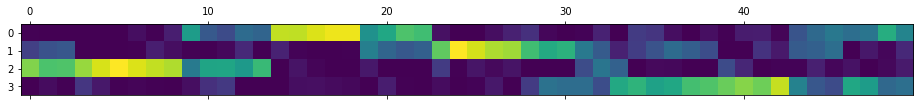

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 4

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 4, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 3) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 3) (lb=0.0001, ub=inf)


## Initialize 

In [11]:
vb_params_dict = structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict)

In [12]:
# take a look at init 
e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                    vb_params_dict['ind_mix_stick_propn_mean'], 
                    vb_params_dict['ind_mix_stick_propn_info'],
                    gh_loc, gh_weights)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [13]:
if k_approx < 6: 
    # find minimizing permutation 
    # only feasible if k_approx is small, 
    # else my computer freezes
    perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)
else: 
    perm = np.arange(k_approx)
    
e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

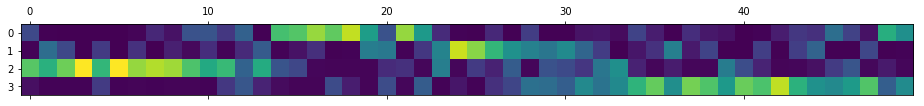

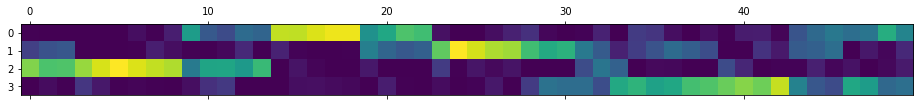

In [14]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

In [15]:
import cluster_quantities_lib

In [16]:
cluster_quantities_lib.get_e_number_clusters_from_logit_sticks(vb_params_dict['ind_mix_stick_propn_mean'], 
                                        vb_params_dict['ind_mix_stick_propn_info'],
                                            n_obs, threshold = 0,
                                            n_samples = 1000,
                                            unv_norm_samples = None)

array([3.62333809, 3.54028172, 3.5224796 , 3.2578637 , 3.71903746,
       3.31655249, 3.55057307, 3.45892392, 3.58331606, 3.59944438,
       3.71984958, 3.72059919, 3.91893109, 3.70089045, 3.63339965,
       3.68335809, 3.59512928, 3.59753001, 3.55079031, 3.6220242 ,
       3.92076894, 3.59483898, 3.78094093, 3.73793847, 3.51388141,
       3.56567772, 3.84419121, 3.73341856, 3.79973979, 3.74847666,
       3.73896677, 3.84560873, 3.85319891, 3.61853716, 3.79373653,
       3.68303417, 3.68941156, 3.68337999, 3.68506418, 3.6233115 ,
       3.52805724, 3.6856181 , 3.49971203, 3.76532869, 3.83892425,
       3.74601283, 3.73577982, 3.69240769, 3.69739366, 3.61125491])

In [17]:
e_z = np.random.random((n_obs, n_pop))

In [19]:
cluster_quantities_lib.get_e_num_large_clusters_from_ez(e_z, n_samples = 20)

(3.7, 0.21000000000000002)

In [ ]:
get_e_num_large_clusters_from_ez

In [27]:
a = np.random.random((3, 2))

In [28]:
a.sum(axis = -1)

array([0.85133414, 0.69441709, 0.74635605])

In [30]:
np.expand_dims(a, 1)

array([[[0.28119555, 0.57013859]],

       [[0.31159807, 0.38281902]],

       [[0.3741415 , 0.37221454]]])

# Set up model

In [15]:
# get loss as a function of vb parameters
get_free_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=structure_model_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_free_vb_params_loss_cached = \
    lambda x : get_free_vb_params_loss(g_obs, x, prior_params_dict, gh_loc, gh_weights, 
                                      true_pop_allele_freq = None, 
                                      true_ind_admix_propn = None)

In [16]:
init_vb_free_params = vb_params_paragami.flatten(vb_params_dict, free = True)

In [17]:
structure_model_lib.get_kl(g_obs, vb_params_dict,
                   prior_params_dict, gh_loc, gh_weights)

13347.90064635658

In [18]:
get_free_vb_params_loss_cached(init_vb_free_params)

13347.90064635658

In [19]:
vb_opt_free_params = opt_lib.optimize_full(get_free_vb_params_loss_cached, init_vb_free_params,
                    bfgs_max_iter = 50, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = 13347.90064636
Iter 1: f = 12891.93705316
Iter 2: f = 11323.28236337
Iter 3: f = 8688.78059108
Iter 4: f = 14964.93915191
Iter 5: f = 7845.93705309
Iter 6: f = 7139.71185471
Iter 7: f = 6361.61396465
Iter 8: f = 5557.58458921
Iter 9: f = 4970.08449813
Iter 10: f = 4770.77805639
Iter 11: f = 4520.97689700
Iter 12: f = 4339.32169662
Iter 13: f = 4242.56022741
Iter 14: f = 4159.58825531
Iter 15: f = 4106.20203607
Iter 16: f = 4059.46383041
Iter 17: f = 4027.58956023
Iter 18: f = 4003.85982227
Iter 19: f = 3980.00870806
Iter 20: f = 3960.22578959
Iter 21: f = 3946.12757522
Iter 22: f = 3929.40060697
Iter 23: f = 3917.81688800
Iter 24: f = 3909.76363935
Iter 25: f = 3899.39040574
Iter 26: f = 3892.52356488
Iter 27: f = 3884.62562023
Iter 28: f = 3875.93863872
Iter 29: f = 3868.03658530
Iter 30: f = 3859.14007183
Iter 31: f = 3849.44640725
Iter 32: f = 3839.22008108
Iter 33: f = 3827.16999604
Iter 34: f = 3814.57147708
Iter 35: f = 3798.77255138
Iter 36: f = 378

In [20]:
vb_opt_dict = vb_params_paragami.fold(vb_opt_free_params, free=True)

In [21]:
ind_mix_stick_propn_mean = vb_opt_dict['ind_mix_stick_propn_mean']
ind_mix_stick_propn_info = vb_opt_dict['ind_mix_stick_propn_info']
pop_freq_beta_params = vb_opt_dict['pop_freq_beta_params']

In [22]:
e_pop_allele_freq = pop_freq_beta_params[:, :, 0] / pop_freq_beta_params.sum(axis=2)

In [23]:
if k_approx < 6: 
    perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
else: 
    perm_best = perm

([array([3., 6., 3., 3., 1., 7., 3., 2., 5., 7.]),
  array([3., 3., 5., 4., 5., 2., 4., 4., 6., 4.]),
  array([6., 4., 4., 4., 5., 4., 1., 1., 5., 6.]),
  array([4., 7., 2., 5., 5., 2., 2., 2., 2., 9.]),
  array([ 0.,  0.,  0.,  0., 20., 20.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0., 20., 20.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0., 23., 17.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0., 24., 16.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0., 26., 14.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0., 27., 13.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0., 28., 12.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0., 24., 16.,  0.,  0.,  0.,  0.])],
 array([0.0409279 , 0.1329199 , 0.2249119 , 0.31690389, 0.40889589,
        0.50088788, 0.59287988, 0.68487188, 0.77686387, 0.86885587,
        0.96084786]),
 <a list of 12 Lists of Patches objects>)

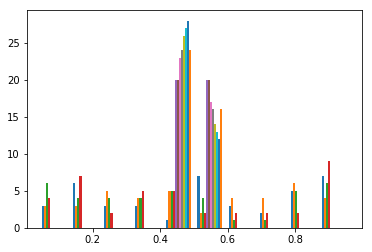

In [24]:
plt.hist(e_pop_allele_freq)

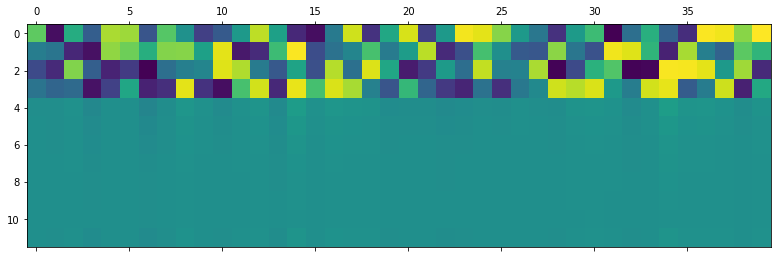

In [25]:
plt.matshow(e_pop_allele_freq[:, perm_best].T)

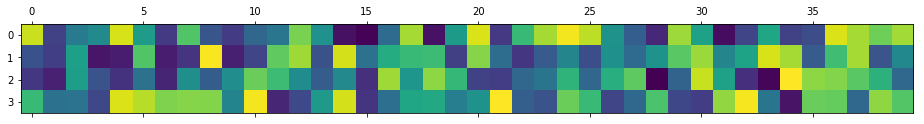

In [26]:
plt.matshow(true_pop_allele_freq.T)

In [27]:
e_ind_admix = dp_modeling_lib.get_e_cluster_probabilities(
                        ind_mix_stick_propn_mean, ind_mix_stick_propn_info,
                        gh_loc, gh_weights)[:, perm_best]

In [28]:
e_ind_admix.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 3, 3, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0])

In [29]:
true_ind_admix_propn.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 3, 3, 0, 0])

In [30]:
np.mean(e_ind_admix.argmax(axis=1) == \
       true_ind_admix_propn.argmax(axis=1))

0.5

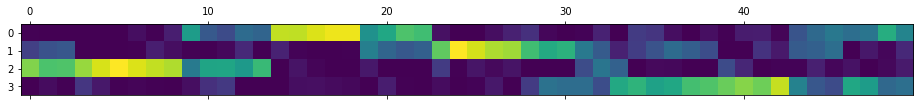

In [31]:
plt.matshow(true_ind_admix_propn.T)

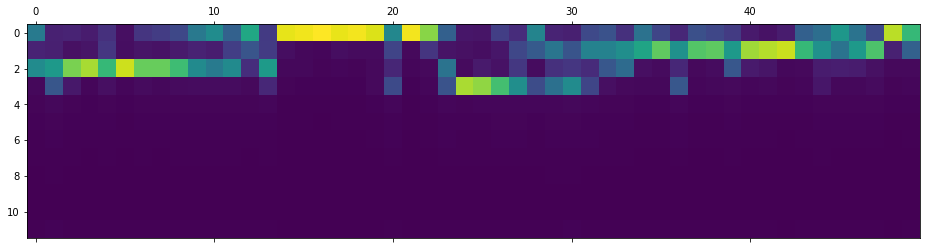

In [32]:
plt.matshow(e_ind_admix.T)

# Parametric sensitivity

## Get linear sensitivity object

In [34]:
get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [35]:
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights),
        opt_par_value = vb_opt_free_params, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
        validate_optimum=False,
        hessian_at_opt=None,
        cross_hess_at_opt=None,
        factorize_hessian=True,
        hyper_par_objective_fun=None,
        grad_tol=1e-8)

In [36]:
hessian_at_opt = vb_sens.get_hessian_at_opt()

## Perturb and re-optimize

In [37]:
prior_perturbed_dict = deepcopy(prior_params_dict)

In [38]:
prior_perturbed_dict['dp_prior_alpha'] = 8

In [39]:
perturbed_objective = \
    lambda x : get_free_vb_params_loss(g_obs, x, 
                                       prior_perturbed_dict, gh_loc, gh_weights, 
                                      true_pop_allele_freq = None, 
                                      true_ind_admix_propn = None)

In [40]:
pert_vb_free_params = \
    opt_lib.optimize_full(perturbed_objective, 
                    deepcopy(vb_opt_free_params),
                    bfgs_max_iter = 0, 
                    netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8, 
                    init_hessian = deepcopy(hessian_at_opt))


 running preconditioned newton; iter =  0
setting preconditioner with hessian: 
running newton steps
Iter 0: f = 5059.54186781
Iter 1: f = 5017.91325591
Iter 2: f = 4940.72680969
Iter 3: f = 4809.44569034
Iter 4: f = 4629.60373099
Iter 5: f = 4515.77186577
Iter 6: f = 4478.82086900
Iter 7: f = 4482.46609133
Iter 8: f = 4470.99841710
Iter 9: f = 4466.02362573
Iter 10: f = 4463.45951637
Iter 11: f = 4463.60839770
Iter 12: f = 4462.81572068
Iter 13: f = 4462.24967124
Iter 14: f = 4461.91612000
Iter 15: f = 4461.60091417
Iter 16: f = 4461.48212929
Iter 17: f = 4462.60442229
Iter 18: f = 4461.37768221
Iter 19: f = 4461.31165687
Iter 20: f = 4461.15418163
Iter 21: f = 4461.11247379
Iter 22: f = 4461.11157005
Iter 23: f = 4461.09507905
Iter 24: f = 4461.08237523
Iter 25: f = 4461.08181775
Iter 26: f = 4461.08172933
Iter 27: f = 4461.08172917
Iter 28: f = 4461.08172917
Iter 29: f = 4461.08172917
         Current function value: 4461.081729
         Iterations: 28
         Function evaluations

In [41]:
# non-zero if optimization went somewhere
np.max(np.abs(pert_vb_free_params - vb_opt_free_params))

4.2457385064678625

### linear response

In [42]:
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_perturbed_dict, free = True))

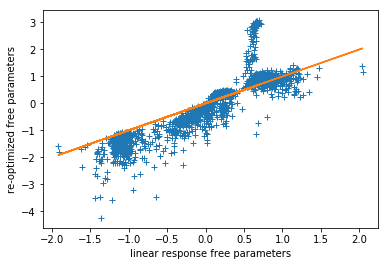

In [43]:
plt.plot(lr_vb_free_params - vb_opt_free_params, 
         pert_vb_free_params - vb_opt_free_params, '+')

plt.plot(lr_vb_free_params - vb_opt_free_params, 
        lr_vb_free_params - vb_opt_free_params, '-')

plt.ylabel('re-optimized free parameters')
plt.xlabel('linear response free parameters')

# Perturb for a range of alphas

In [44]:
alpha_vec = np.arange(1, 12)

In [25]:
pert_vb_free_params_array = np.zeros((len(alpha_vec), len(vb_opt_free_params)))
lr_vb_free_params_array = np.zeros((len(alpha_vec), len(vb_opt_free_params)))

for i in range(len(alpha_vec)): 
    print('###########################\n')
    print('optimizing alpha = {}\n'.format(alpha_vec[i]))
    print('###########################\n')
    # get prior perturbation 
    prior_perturbed_dict = deepcopy(prior_params_dict)
    prior_perturbed_dict['dp_prior_alpha'] = alpha_vec[i]
    
    # get perturbed objective 
    perturbed_objective = \
        lambda x : get_free_vb_params_loss(g_obs, x, 
                                           prior_perturbed_dict, gh_loc, gh_weights, 
                                          true_pop_allele_freq = None, 
                                          true_ind_admix_propn = None)
    # optimize 
    pert_vb_free_params = \
        opt_lib.optimize_full(perturbed_objective, 
                        deepcopy(vb_opt_free_params),
                        bfgs_max_iter = 0, 
                        netwon_max_iter = 50,
                        max_precondition_iter = 10,
                        gtol=1e-8, ftol=1e-8, xtol=1e-8, 
                        init_hessian = deepcopy(hessian_at_opt))
    
    # get linear response
    lr_vb_free_params = \
        vb_sens.predict_opt_par_from_hyper_par(
            prior_params_paragami.flatten(prior_perturbed_dict, free = True))
    
    pert_vb_free_params_array[i, :] = pert_vb_free_params
    lr_vb_free_params_array[i, :] = lr_vb_free_params
    

NameError: name 'alpha_vec' is not defined

In [ ]:
# check results:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_vb_free_params_array[i, :] - vb_opt_free_params, 
            pert_vb_free_params_array[i, :] - vb_opt_free_params, '+')
    plt.plot(lr_vb_free_params_array[i, :] - vb_opt_free_params, 
            lr_vb_free_params_array[i, :] - vb_opt_free_params, '-')
    
    plt.title('free params at alpha = {}'.format(alpha_vec[i]))
    plt.xlabel('lr')
    plt.ylabel('re-optimized')

# check how vb expectations change

In [ ]:
def get_vb_expectations(vb_free_params, vb_params_paragami, true_pop_allele_freq): 
    # get vb dict 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free=True)
    
    # get popoulation frequencies
    e_pop_allele_freq = dp_modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    # find minimizing permutation 
    if true_pop_allele_freq.shape[1] < 6: 
        perm = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
    else: 
        perm = np.arange(true_pop_allele_freq.shape[1])
    
    # get individual admixutures
    e_ind_admix = dp_modeling_lib.get_e_cluster_probabilities(
                        vb_params_dict['ind_mix_stick_propn_mean'], 
                        vb_params_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)[:, perm]
    
    return e_ind_admix, e_pop_allele_freq[:, perm]

In [ ]:
opt_e_ind_admix, opt_e_pop_allele_freq = get_vb_expectations(vb_opt_free_params, 
                                                                vb_params_paragami, 
                                                                true_pop_allele_freq)

pert_e_ind_admix_array = np.zeros((len(alpha_vec), len(opt_e_ind_admix.flatten())))
lr_e_ind_admix_array = np.zeros((len(alpha_vec), len(opt_e_ind_admix.flatten())))

pert_e_pop_allele_freq_array = np.zeros((len(alpha_vec), len(opt_e_pop_allele_freq.flatten())))
lr_e_pop_allele_freq_array = np.zeros((len(alpha_vec), len(opt_e_pop_allele_freq.flatten())))

for i in range(len(alpha_vec)): 
    pert_e_ind_admix, pert_e_pop_allele_freq = \
                    get_vb_expectations(pert_vb_free_params_array[i, :], 
                                                vb_params_paragami, 
                                                true_pop_allele_freq)
    
    lr_e_ind_admix, lr_e_pop_allele_freq = \
                    get_vb_expectations(lr_vb_free_params_array[i, :], 
                                                vb_params_paragami, 
                                                true_pop_allele_freq)
    
    _, axarr = plt.subplots(1, 2, figsize = (15, 15))
    axarr[0].matshow(pert_e_ind_admix.T)
    axarr[1].matshow(lr_e_ind_admix.T)
    axarr[0].set_title('alpha = {}\n'.format(alpha_vec[i]))
    axarr[1].set_title('alpha = {}\n'.format(alpha_vec[i]))
    
    plt.tight_layout()
    
    pert_e_ind_admix_array[i, :] = pert_e_ind_admix.flatten()
    lr_e_ind_admix_array[i, :] = lr_e_ind_admix.flatten()
    
    pert_e_pop_allele_freq_array[i, :] = pert_e_pop_allele_freq.flatten()
    lr_e_pop_allele_freq_array[i, :] = lr_e_pop_allele_freq.flatten()

In [ ]:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), 
            pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), '+')
    plt.plot(pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), 
            pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), '-')
    plt.title('individual admixtures, alpha = {}'.format(alpha_vec[i]))
    
    plt.xlabel('lr')
    plt.ylabel('re-opt')

In [ ]:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), 
            pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), '+')
    plt.plot(pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), 
            pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), '-')
    plt.title('population frequencies, alpha = {}'.format(alpha_vec[i]))
    plt.xlabel('lr')
    plt.ylabel('re-opt')